In [1]:
import numpy as np
import os
import pandas as pd
import sys
import itertools
import glob
import json
import copy
import urllib
import datetime
import inspect
from importlib import reload
import matplotlib.pyplot as plt
import matplotlib as mpl
from copy import deepcopy as dcopy
from gwpy.time import tconvert

sys.path.append(os.path.join('..', '..', 'gw_detection_ias'))
import utils as ias_utils
import triggers_single_detector as trig
import template_bank_params_O3a as tbp
import plots_publication as ppub
import gw_pe_plotting as peplot
import gw_parameter_dictionary as gwpdic
from gw_pe import estimate_mchirp_range
from pop_inference import gw_pe_bookkeeping
bookkeeping = gw_pe_bookkeeping.bookkeeping
from o3a_catalog_tables import *

sys.path.append('..')

from cogwheel import postprocessing, sampling, posterior, prior, gw_prior, utils, data, waveform, grid
from cogwheel import cosmology as cosmo
from cogwheel import _private_ias

from _private_scratch import analysis_handle as ahand
from _private_scratch import parameter_aliasing as aliasing
from _private_scratch import parameter_label_formatting as labform
from _private_scratch import pe_plotting as cwplot
from _private_scratch import standard_intrinsic_transformations as pxform

#### EVENTS WITH COGWHEEL PE:
all_pe_evnames = ['GW150914',
 'GW151012',
 'GW151216',
 'GW151226',
 'GW170104',
 'GW170121',
 'GW170202',
 'GW170304',
 'GW170403',
 'GW170425',
 'GW170608',
 'GW170727',
 'GW170729',
 'GW170809',
 'GW170814',
 'GW170817A',
 'GW170818',
 'GW170823',
 'GW190408_181802',
 'GW190412',
 'GW190412_053044',
 'GW190413_052954',
 'GW190413_134308',
 'GW190421_213856',
 'GW190424_180648',
 'GW190426_152154',
 'GW190503_185404',
 'GW190510_201259',
 'GW190512_180714',
 'GW190513_205428',
 'GW190514_065416',
 'GW190517_055101',
 'GW190519_153544',
 'GW190521',
 'GW190521_074359',
 'GW190527_092055',
 'GW190602_175927',
 'GW190605_053717',
 'GW190606_061230',
 'GW190611_133220',
 'GW190620_030421',
 'GW190625_013821',
 'GW190625_074145',
 'GW190629_211545',
 'GW190630_185205',
 'GW190701_203306',
 'GW190704_104834',
 'GW190705_225533',
 'GW190706_222641',
 'GW190707_083226',
 'GW190707_093326',
 'GW190708_232457',
 'GW190711_030756',
 'GW190718_160159',
 'GW190719_215514',
 'GW190720_000836',
 'GW190725_174728',
 'GW190727_060333',
 'GW190728_064510',
 'GW190731_140936',
 'GW190803_022701',
 'GW190805_211137',
 'GW190814',
 'GW190814_192009',
 'GW190818_232544',
 'GW190821_124821',
 'GW190828_063405',
 'GW190828_065509',
 'GW190906_054335',
 'GW190908_161547',
 'GW190908_182359',
 'GW190909_114149',
 'GW190910_012619',
 'GW190910_112807',
 'GW190915_235702',
 'GW190916_200658',
 'GW190917_114810',
 'GW190920_113516',
 'GW190924_021846',
 'GW190926_050336',
 'GW190929_012149',
 'GW190930_133541']

# ones which also have version sampled with comoving VT prior:
all_pe_evnames_comov = ['GW190426_152154',
 'GW190510_201259',
 'GW190605_053717',
 'GW190606_061230',
 'GW190611_133220',
 'GW190625_013821',
 'GW190625_074145',
 'GW190629_211545',
 'GW190704_104834',
 'GW190705_225533',
 'GW190707_083226',
 'GW190711_030756',
 'GW190718_160159',
 'GW190725_174728',
 'GW190805_211137',
 'GW190814_192009',
 'GW190818_232544',
 'GW190821_124821',
 'GW190906_054335',
 'GW190908_161547',
 'GW190908_182359',
 'GW190910_012619',
 'GW190916_200658',
 'GW190917_114810',
 'GW190920_113516',
 'GW190926_050336']

def fmt(num, **kwargs):
    if hasattr(num, '__len__'):
        return [fmt(v, **kwargs) for v in num]
    return labform.fmt_num(num, **kwargs)

162 events, 34 from LVC catalog ({'GW190917_114629'} required shift) + 2 from LVC marginals
missing 3 with HL:
['GW190924_021846', 'GW190403_051519', 'GW190521_030229']
missing 6 LV and HV events:
['GW190910_112807', 'GW190620_030421', 'GW190814_211039', 'GW190630_185205', 'GW190708_232457', 'GW190925_232845']

restricting to IFAR > .5:
52 events, 33 from LVC catalog ({'GW190917_114629'} required shift) + 1 from LVC marginals
missing 4 with HL:
['GW190924_021846', 'GW190403_051519', 'GW190701_203306', 'GW190521_030229']
missing 6 LV and HV events:
['GW190910_112807', 'GW190620_030421', 'GW190814_211039', 'GW190630_185205', 'GW190708_232457', 'GW190925_232845']

restricting to IFAR > 3:
35 events, 31 from LVC catalog + 0 from LVC marginals
missing 6 with HL:
['GW190924_021846', 'GW190403_051519', 'GW190917_114630', 'GW190426_190642', 'GW190701_203306', 'GW190521_030229']
missing 6 LV and HV events:
['GW190910_112807', 'GW190620_030421', 'GW190814_211039', 'GW190630_185205', 'GW190708_23

In [2]:
from IPython.display import IFrame
%matplotlib notebook
%config Completer.use_jedi = False

In [3]:
approximant = 'IMRPhenomXPHM'
prior_class = 'IASPrior'
prior_class_comoving = 'IASPriorComovingVT'
parentdir = '/scratch/srolsen/GW/O3a/PE/'
# NOTE: all_ias_cands[evname] will give dict with trigger information if evname from O3a
## below are the most commonly used keys as lambda functions taking eventname argument
ifar_of_evname = lambda evn: all_ias_cands[evn]['ifar_years']
pastro_of_evname = lambda evn: all_ias_cands[evn]['pastro_mz']
snr2_of_evname = lambda evn: np.array([all_ias_cands[evn]['snr2_H1'], all_ias_cands[evn]['snr2_L1']])
calpha_of_evname = lambda evn: np.array(all_ias_cands[evn]['calpha'])

**EXAMPLE: Single Event**

In [15]:
evn_check = 'GW190707_093326'

### this has the trigger info
cdic_check = all_ias_cands.get(evn_check)
if cdic_check is not None:
    print(f'{evn_check}: IFAR = {fmt(ifar_of_evname(evn_check))} (y),',
          f'snr2[H,L] = {fmt(snr2_of_evname(evn_check))},',
          f'pastro = {ifar_of_evname(evn_check)}')
### IASPrior and IASPriorComovingVT latest PE results loaded if they exist
pecheck, pecheck_comov = None, None
if evn_check in all_pe_evnames:
    pecheck = ahand.AnalysisHandle.from_evname(evn_check, complete_samples=True)
    # after loading PE set name to include some info (used in plot titles/labels)
    pecheck.name = (f'IASPrior, lnLmax = '+fmt(pecheck.lnL(pecheck.best_par_dic))
                    +', lnLref = '+fmt(pecheck.lnL(pecheck.likelihood.par_dic_0)))
    print(f'--> {len(pecheck.samples)} samples from '+pecheck.name)
else:
    print(f'[[ NO Cogwheel PE of {evn_check} for IASPrior ]]')
if evn_check in all_pe_evnames_comov:
    pecheck_comov = ahand.AnalysisHandle.from_evname(evn_check,
                        prior_class=prior_class_comoving, complete_samples=True)
    pecheck_comov.name = (f'IASPriorComovingVT, lnLmax = '+
        fmt(pecheck_comov.lnL(pecheck_comov.best_par_dic))+', lnLref = '
        +fmt(pecheck_comov.lnL(pecheck_comov.likelihood.par_dic_0)))
    print(f'--> {len(pecheck_comov.samples)} samples from '+pecheck_comov.name)
else:
    print(f'[[ NO Cogwheel PE of {evn_check} for IASPriorComovingVT ]]')

GW190707_093326: IFAR = inf (y), snr2[H,L] = ['64', '98'], pastro = inf
--> 38250 samples from IASPrior, lnLmax = 91, lnLref = 93
[[ NO Cogwheel PE of GW190707_093326 for IASPriorComovingVT ]]


In [10]:
## EXAMPLE: take 2 samples from different regions and compute cosine
######################################################################
# get best samples at ~ equal mass (eqm) and extreme mass ratio (uneq)
pdic_eqm = pecheck.get_best_par_dics(key_rngs={'q': (0.4, 1)})
pdic_uneq = pecheck.get_best_par_dics(key_rngs={'q': (0, 0.4)})
# get frequency-domain waveforms (unwhitened) at all detectors
dets_h_f_eqm = pecheck.likelihood._get_h_f(pdic_eqm)
dets_h_f_uneq = pecheck.likelihood._get_h_f(pdic_uneq)
# get whitened time domain from these
dets_hw_t_eqm = pecheck.likelihood._get_whitened_td(dets_h_f_eqm)
dets_hw_t_uneq = pecheck.likelihood._get_whitened_td(dets_h_f_uneq)
# compute match at each detector
print(f'match at {[k for k in pecheck.evdata.detector_names]} =',
     fmt([ias_utils.match(h1, h2, allow_phase=False, allow_shift=False,
                          return_cov=False) for h1, h2 in
          zip(dets_hw_t_eqm, dets_hw_t_uneq)]))

match at ['H', 'L'] = ['0.97', '0.97']


<IPython.core.display.Javascript object>


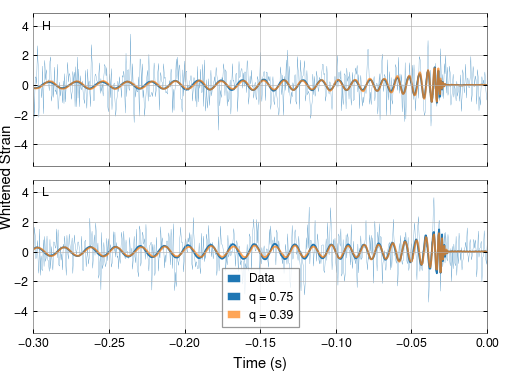

In [32]:
## EXAMPLE: plot whitened time domain waveform
#################################################
ff1 = pecheck.plot_whitened_wf(pdic_eqm, label=f"q = {fmt(pdic_eqm['m2']/pdic_eqm['m1'])}",
                               trng=(-.3, 0))
ff1 = pecheck.plot_whitened_wf(pdic_uneq, label=f"q = {fmt(pdic_uneq['m2']/pdic_uneq['m1'])}",
                               trng=(-.3, 0), fig=ff1, plot_data=False, alpha=0.7)
plt.legend()

In [ ]:
## EXAMPLE: plot waveform amplitudes and phases by modes
##########################################################
ff2, aax2 = pecheck.plot_wf_amp(pecheck.best_par_dic, whiten=True,
                                 by_m=True, xlim=(20, 200))
ff3, aax3 = pecheck.plot_wf_phase(pecheck.best_par_dic,
                                  by_m=True, xlim=(20, 200))

<IPython.core.display.Javascript object>


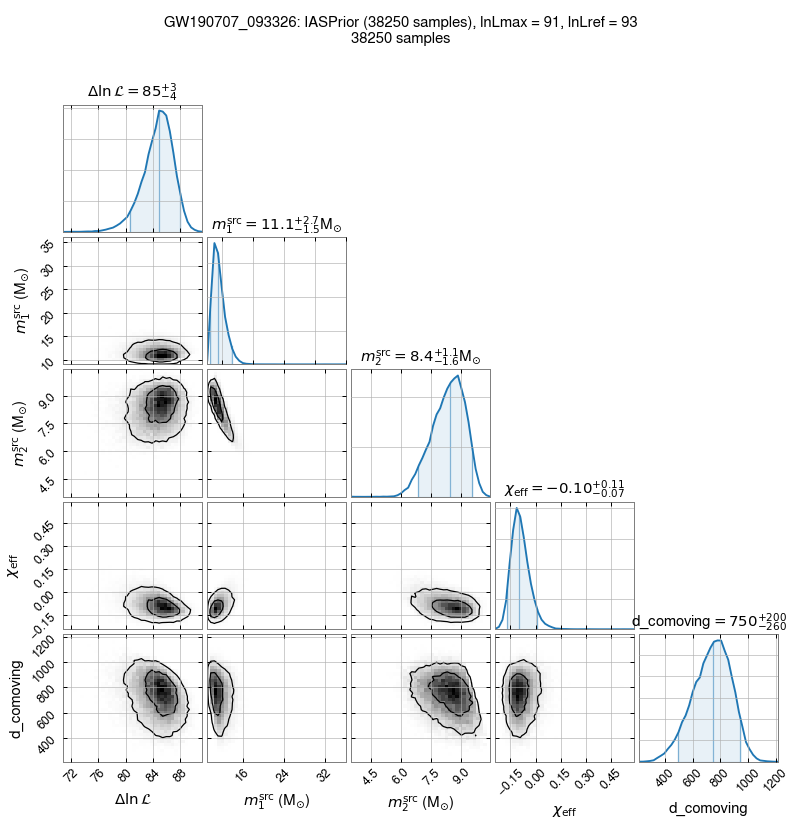

In [14]:
## EXAMPLE: CORNER PLOTTING
#################################################
parkeys = ['lnl', 'm1_source', 'm2_source', 'chieff', 'd_comoving']
## assume that the regular prior exists and if the comoving exists plot them
# both on a single corner plot, otherwise just the IASPrior
if pecheck_comov is not None:
    ff4, aax4 = pecheck.corner_plot_comparison([pecheck_comov], parkeys=parkeys)
else:
    ff4, aax4 = pecheck.corner_plot(parkeys)

<IPython.core.display.Javascript object>


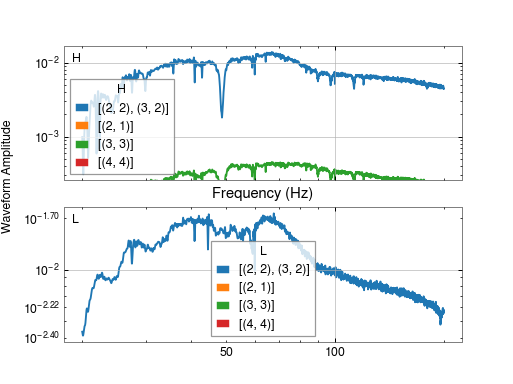

<IPython.core.display.Javascript object>


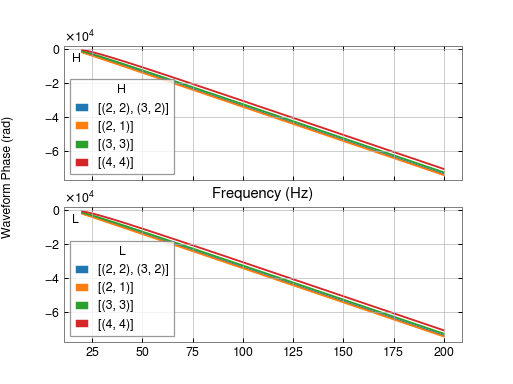

In [24]:
## EXAMPLE: plot waveform amplitudes and phases by modes
##########################################################
ff5, aax5 = pecheck.plot_wf_amp(pecheck.best_par_dic, whiten=True,
                                 by_m=True, xlim=(20, 200))
ff6, aax6 = pecheck.plot_wf_phase(pecheck.best_par_dic,
                                  by_m=True, xlim=(20, 200))